In [4]:
import datetime
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import image, ImageDataGenerator, img_to_array ,array_to_img, load_img
np.random.seed(123)

Using TensorFlow backend.


In [5]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
train_data_dir = '../data/train'  
validation_data_dir = '../data/validation'  
test_data_dir = '../data/test'
   
# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50

In [6]:
datagen = ImageDataGenerator(rescale=1./255) 

In [7]:
from keras.applications import VGG19

In [8]:
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(64,64,3)
                )

In [9]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [10]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 2, 2, 512)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(64, 64), 
        batch_size = batch_size, 
        class_mode='binary',
        shuffle=False)
    i=0

    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [35]:
# you should be able to divide sample_amount by batch_size!!
train_features, train_labels = extract_features(train_data_dir, 13412) # 13412
validation_features, validation_labels = extract_features(validation_data_dir, 2549) #2549 
test_features, test_labels = extract_features(test_data_dir, 1845) #1845

train_features = np.reshape(train_features, (13412, 2 * 2 * 512))
validation_features = np.reshape(validation_features, (2549, 2 * 2 * 512))
test_features = np.reshape(test_features, (1845, 2 * 2 * 512))

Found 13412 images belonging to 6 classes.
Found 2549 images belonging to 6 classes.
Found 1845 images belonging to 6 classes.


In [36]:
test_features.shape

(1845, 2048)

In [37]:
test_labels.shape

(1845,)

In [38]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, 
                       activation='relu', 
                       input_dim=2 * 2 * 512))

model.add(layers.Dense(6, 
                       activation='softmax'))


In [39]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, 
                    train_labels,
                    epochs=20,
                    batch_size=10,
                    validation_data=(validation_features, 
                                     validation_labels))

Train on 13412 samples, validate on 2549 samples
Epoch 1/20
13412/13412 [==============================] - 12s 859us/step - loss: 0.9691 - acc: 0.6471 - val_loss: 0.8827 - val_acc: 0.6783
Epoch 2/20
13412/13412 [==============================] - 11s 785us/step - loss: 0.7639 - acc: 0.7255 - val_loss: 0.7929 - val_acc: 0.7105
Epoch 3/20
13412/13412 [==============================] - 11s 793us/step - loss: 0.7015 - acc: 0.7465 - val_loss: 0.7260 - val_acc: 0.7419
Epoch 4/20
13412/13412 [==============================] - 13s 961us/step - loss: 0.6591 - acc: 0.7616 - val_loss: 0.7410 - val_acc: 0.7387
Epoch 5/20
13412/13412 [==============================] - 12s 888us/step - loss: 0.6269 - acc: 0.7778 - val_loss: 0.7638 - val_acc: 0.7297
Epoch 6/20
13412/13412 [==============================] - 11s 819us/step - loss: 0.5990 - acc: 0.7855 - val_loss: 0.7117 - val_acc: 0.7579
Epoch 7/20
13412/13412 [==============================] - 11s 846us/step - loss: 0.5765 - acc: 0.7944 - val_loss: 0.7

In [40]:
results_test = model.evaluate(test_features, test_labels)
results_test

1845/1845 [==============================] - 0s 111us/step


[0.7975897805154485, 0.7387533878569358]

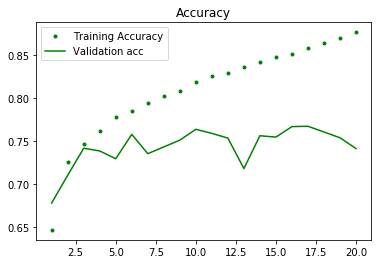

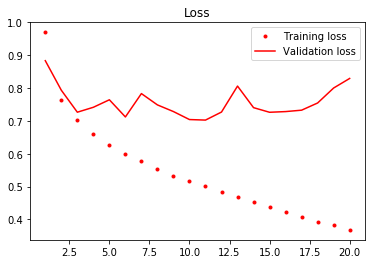

In [41]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

# Image functions

In [ ]:
import matplotlib.image as mpimg

In [ ]:
def read_image(file_path, resize=True):
    image_path = file_path

    orig = mpimg.imread(image_path)  

    print("[INFO] loading and preprocessing image...")  
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  

    # important! otherwise the predictions will be '0'
    if resize:
        image = image / 255  

    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
path = '../data/test/elephants/OIP-VC6pX0aP4-OEoBF2nO997wHaIS.jpeg'

In [ ]:
def show_img(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    print(type(img))

    x = image.img_to_array(img)
    print(type(x))
    print(x.shape)
    plt.imshow(x/255.)